In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import glob


Mounted at /content/drive


In [ ]:
from tensorflow.keras.utils import load_img
from tensorflow import keras
import PIL
import PIL.Image
import PIL.ImageOps
!pip install utils
import utils


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Need to decide what image IO to use
import cv2
import skimage
import imageio as iio
from scipy.ndimage import rotate


In [ ]:
AROI_DATA = Path("/content/drive/MyDrive/Colab Notebooks/OCT-images-segmentation-master/AROI_labelled_scans")
OCTID_DATA = Path("/content/drive/MyDrive/Colab Notebooks/OCT-images-segmentation-master/OCTID")
assert AROI_DATA.exists() and OCTID_DATA.exists()
raw_images = sorted([file for file in AROI_DATA.glob("**/raw/labeled/*png")])
segmented_images = sorted([file for file in AROI_DATA.glob("**/mask/number/*png")])

(array([[256.,   0.,   0., ...,   0.,   0.,   0.],
        [256.,   0.,   0., ...,   0.,   0.,   0.],
        [256.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0., 256.,   0.],
        [  0.,   0.,   0., ...,   0., 256.,   0.],
        [  0.,   0.,   0., ...,   0., 256.,   0.]]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 512 Lists of Patches objects>)

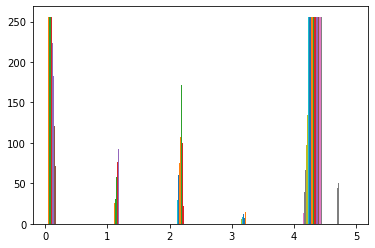

In [ ]:

plt.hist(load_img(segmented_images[5]/.255, target_size=img_size, color_mode="grayscale"))

In [ ]:
from sklearn.model_selection import train_test_split
x_train, X_test, y_train, Y_test = train_test_split(raw_images, segmented_images, test_size=0.2, shuffle=True)
X_train, X_valid,Y_train, Y_valid=train_test_split(x_train, y_train, test_size=0.2, shuffle=True)

In [ ]:
class OCT(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""
    seed = 42
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_train_paths = input_img_paths
        self.target_train_paths = target_img_paths

    def __len__(self):
        return len(self.target_train_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_train_paths = self.input_train_paths[i : i + self.batch_size]
        batch_target_train_paths = self.target_train_paths[i : i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (1,), dtype="float32")
        flp = np.zeros((batch_size,) + self.img_size + (1,))
        angle = np.zeros((batch_size,) + self.img_size + (1,))
        
        for j, path in enumerate(batch_input_train_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img=np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
            seed = 13
            np.random.seed = 13
            #flipping
            flp [j] = np.random.randint(0,3)
            flp = np.append (flp, flp[j])
            if flp [j] ==1:
              img = np.fliplr(img)
            #rotating
            angle[j] = np.random.randint(-8, 8)
            angle = np.append(angle, angle[j])
            img = rotate(img, angle[j], reshape=False, mode='nearest', order=0)
            x[j] = img/.255
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_train_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
            if flp [j] ==1:
              img = np.fliplr(img)
            img = rotate(img, angle[j], reshape=False, mode='nearest', order=0)
            y[j] = img
        return x, y

class OCT_test(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_train_paths = input_img_paths
        self.target_train_paths = target_img_paths

    def __len__(self):
        return len(self.target_train_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_train_paths = self.input_train_paths[i : i + self.batch_size]
        batch_target_train_paths = self.target_train_paths[i : i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_input_train_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img=np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
            x[j] = img/.255
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_train_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
            y[j] = img
        return x, y

In [ ]:
batch_size=4
IMG_WIDTH_ORIGINAL=512
IMG_HEIGHT_ORIGINAL=1024
IMG_WIDTH = 256
IMG_HEIGHT = 512
IMG_CHANNELS = 1 # grayscale images
img_size = (IMG_HEIGHT, IMG_WIDTH)
num_classes = 8 #8 in case just fluids is 4, in case fluids and layers is 8
batch_size = 4 # try 4, 8, 12, 16, 32
train_gen = OCT(batch_size, img_size, X_train, Y_train)
valid_gen= OCT_test(batch_size, img_size, X_valid, Y_valid)

### standard U-net
*   with BN

In [ ]:
from tensorflow.keras import layers
import keras
def get_model(img_size, num_classes):
    
    inputs = keras.Input(shape=img_size + (1,))

    conv1 = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation("relu")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation("relu")(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, (3, 3), padding='same')(pool2)
    conv3 = layers.Conv2D(128, (3, 3), padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation("relu")(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(256, (3, 3), padding='same')(pool3)
    conv4 = layers.Conv2D(256, (3, 3), padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation("relu")(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(512, (3, 3), padding='same')(pool4)
    conv5 = layers.Conv2D(512, (3, 3), padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation("relu")(conv5)

    x6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = layers.add([x6, conv4])
    conv6 = layers.Conv2D(256, (3, 3), padding='same')(up6)
    conv6 = layers.Conv2D(256, (3, 3), padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation("relu")(conv6)

    x7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2),padding='same')(conv6)
    up7 = layers.add([x7, conv3])
    conv7 = layers.Conv2D(128, (3, 3), padding='same')(up7)
    conv7 = layers.Conv2D(128, (3, 3), padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation("relu")(conv7)

    x8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = layers.add([x8, conv2])
    conv8 = layers.Conv2D(64, (3, 3), padding='same')(up8)
    conv8 = layers.Conv2D(64, (3, 3), padding='same')(conv8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Activation("relu")(conv8)

    x9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = layers.add([x9, conv1])
    conv9 = layers.Conv2D(32, (3, 3), padding='same')(up9)
    conv9 = layers.Conv2D(32, (3, 3), padding='same')(conv9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Activation("relu")(conv9)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(conv9)
    
    # Define the model
    model = keras.Model(inputs, outputs)
   
       
    return model

    


# Build model
model = get_model(img_size, num_classes)
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
!pip install keras-adabound

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for keras-adabound: filename=keras_adabound-0.6.0-py3-none-any.whl size=6607 sha256=1b7bf323d3e85facde85f90bc4c0f9d34ef93eec54a54f3ad947478fda21929f
  Stored in directory: /root/.cache/pip/wheels/bc/8a/34/f7fd8b562417782e64c61fd17829dc5a153a46ec58065aa570
Successfully built keras-adabound


In [ ]:
from keras_adabound import AdaBound
opt=AdaBound(learning_rate=1e-3, final_lr=0.1)

In [ ]:
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy")


In [ ]:
callbacks = [
    #keras.callbacks.ModelCheckpoint("OCT_segmentation.h5", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1)
]
# Train the model, doing validation at the end of each epoch.
epochs = 300
model_history = model.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=callbacks)

Epoch 1/300
181/181 [==============================] - 863s 5s/step - loss: 0.3291 - val_loss: 0.4745
Epoch 2/300
181/181 [==============================] - 32s 177ms/step - loss: 0.1298 - val_loss: 0.3408
Epoch 3/300
181/181 [==============================] - 32s 177ms/step - loss: 0.1048 - val_loss: 0.1348
Epoch 4/300
181/181 [==============================] - 32s 179ms/step - loss: 0.0931 - val_loss: 0.1419
Epoch 5/300
181/181 [==============================] - 32s 179ms/step - loss: 0.0870 - val_loss: 0.1131
Epoch 6/300
181/181 [==============================] - 34s 186ms/step - loss: 0.0797 - val_loss: 0.1075
Epoch 7/300
181/181 [==============================] - 33s 181ms/step - loss: 0.0761 - val_loss: 0.1098
Epoch 8/300
181/181 [==============================] - 33s 181ms/step - loss: 0.0719 - val_loss: 0.1273
Epoch 9/300
181/181 [==============================] - 33s 181ms/step - loss: 0.0695 - val_loss: 0.0793
Epoch 10/300
181/181 [==============================] - 33s 180ms/

In [ ]:
model.save('model_ada_1_31')

In [ ]:
/content/model_ada_1_31

In [ ]:
def plot_performance(history,batch_size):
  plt.figure(figsize=(18,10))
  plt.style.use('ggplot')
  # Plot data on the first subplot
  plt.plot(history.history['val_loss'],'.--',label='Valid Loss')
  plt.plot(history.history['loss'],'.--',label='Training Loss')
  plt.title('Model Loss for the ada (batch size={})'.format(batch_size))
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(loc='best')

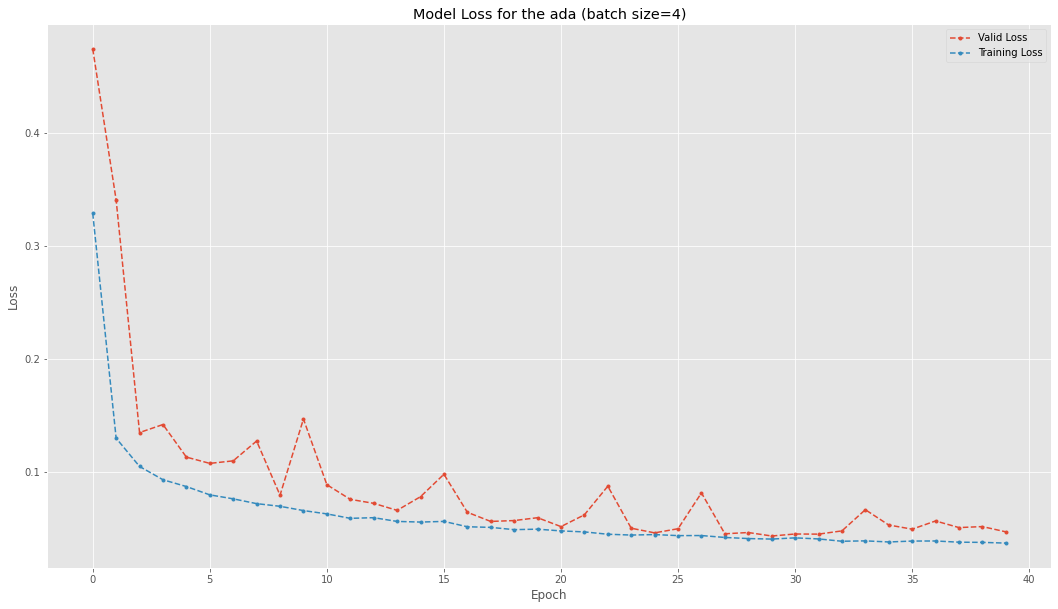

In [ ]:
import matplotlib.pyplot as plt
plot_performance(model_history,4)


In [ ]:
test_gen = OCT_test(batch_size, img_size, X_test, Y_test)
test_preds = model.predict(test_gen)

57/57 [==============================] - 206s 4s/step


In [ ]:
print(np.shape(test_preds))

(228, 512, 256, 8)


In [ ]:
black = np.array([0, 0, 0, 255])
white = np.array([255, 255, 255, 255])
yellow = np.array([255, 255, 0, 255])
red = np.array([255, 0, 0, 255]) 
blue = np.array([0, 0, 255, 255])
light_blue = np.array([0, 255, 255, 255])
green = np.array([0, 255, 0, 255])
pink = np.array([255, 0, 255, 255]) 

# function which trasform mask values 0,1,2,3,4,5,6,7 into colours
def num_to_colors (mask, height, width):
    col_mask = np.zeros((height, width, 4))
    for j in range (0,width):
        for i in range (0,height):
            if (mask[i,j]==0):
                col_mask[i,j]=black
            elif (mask[i,j]==1):
                col_mask[i,j]= red
            elif (mask[i,j]==2):
                col_mask[i,j]= yellow
            elif (mask[i,j]==3):
                col_mask[i,j]= white
            elif (mask[i,j]==4):
                col_mask[i,j]= blue
            elif (mask[i,j]==5):
                col_mask[i,j]=light_blue
            elif (mask[i,j]==6):
                col_mask[i,j]=pink
            elif (mask[i,j]==7):
                col_mask[i,j]=green
           
    return col_mask

Image id: 57


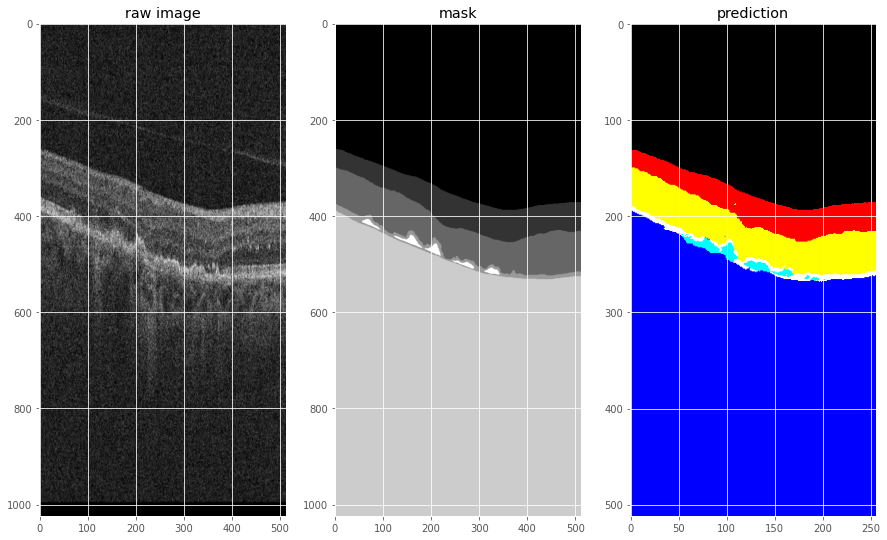

In [ ]:
#m=os.listdir(X_test[0])
i = np.random.randint(0,len(X_test))
#i=11 #0, 133, 119
print('Image id:', i )
#print('Image id:', i ,  m[i])
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title('raw image')
raw = PIL.ImageOps.autocontrast(load_img(X_test[i]))
plt.imshow(raw)
plt.subplot(1, 3, 2)
plt.title('mask')
mask = PIL.ImageOps.autocontrast(load_img(Y_test[i]))
plt.imshow(mask)
plt.subplot(1, 3, 3)
plt.title('prediction')
pred = np.argmax(test_preds[i], axis=-1)
pred = np.expand_dims(pred, axis=-1)
pred = num_to_colors(pred, IMG_HEIGHT, IMG_WIDTH)
#pred = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(pred))
plt.imshow(pred)


plt.show()

In [ ]:
i= 0

mask = load_img(Y_test[i], target_size = img_size, color_mode="grayscale")
mask = np.reshape(mask, (IMG_HEIGHT, IMG_WIDTH, 1))

pred = np.argmax(test_preds[i], axis=-1)
pred = np.expand_dims(pred, axis=-1)

pred_vector=pred.flatten()
mask_vector=mask.flatten()


# i range from 1 to number of images in val (test) set
for i in range(1, 32):
  mask = load_img(Y_test[i], target_size = img_size, color_mode="grayscale")
  mask = np.reshape(mask, (IMG_HEIGHT, IMG_WIDTH, 1))    
  mask_vector = np.concatenate((mask_vector, mask.flatten()), axis=0)
  pred = np.argmax(test_preds[i], axis=-1)
  pred = np.expand_dims(pred, axis=-1)
  pred_vector = np.concatenate((pred_vector, pred.flatten()), axis=0)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(mask_vector, pred_vector)

In [ ]:
print(cf_matrix)

[[1501891    2413       0       0   11775       0       0       0]
 [   1743  205998    9807       0       0       0       0      53]
 [      0    2134  323501    1426       0      85    2041      76]
 [      0       0    6404   29838    1934    6201    1032       0]
 [      0       0       6    4294 1973969    7135       0       0]
 [      0       0     918    3832     934   55474    1236       0]
 [      0       0    5625     528       0     449   30371       0]
 [     26      75     468       0       0       0      47     565]]


In [ ]:
cf_matrix_normal = cf_matrix.astype('float32') / cf_matrix.sum(axis=1)[:, np.newaxis]
print(cf_matrix_normal )

[[9.90641649e-01 1.59160571e-03 0.00000000e+00 0.00000000e+00
  7.76674566e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [8.01007348e-03 9.46677635e-01 4.50687267e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 2.43565057e-04]
 [0.00000000e+00 6.48114122e-03 9.82500311e-01 4.33088443e-03
  0.00000000e+00 2.58152298e-04 6.19869223e-03 2.30818525e-04]
 [0.00000000e+00 0.00000000e+00 1.41029311e-01 6.57094409e-01
  4.25906759e-02 1.36558832e-01 2.27267722e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.02205496e-06 2.16278400e-03
  9.94240467e-01 3.59372702e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.47129532e-02 6.14161618e-02
  1.49693881e-02 8.89091900e-01 1.98095971e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.52138047e-01 1.42806913e-02
  0.00000000e+00 1.21439970e-02 8.21437265e-01 0.00000000e+00]
 [2.20152413e-02 6.35055038e-02 3.96274344e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.97967824e-02 4.78408129e-01]]

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.2f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

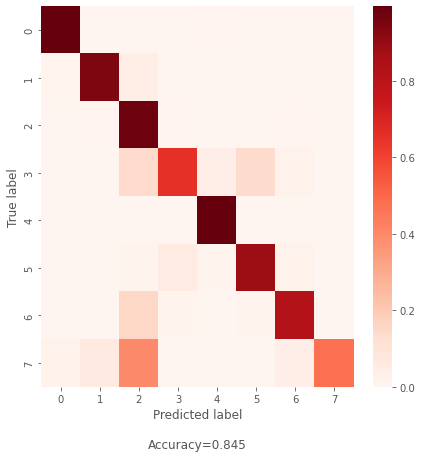

In [ ]:
make_confusion_matrix(cf_matrix_normal, count = False, percent = False, figsize=(7,7), cbar=True, cmap='Reds')

In [ ]:
!pip install pycm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.7/595.7 KB 14.2 MB/s eta 0:00:00


In [ ]:
import pycm
from pycm import *
cm = ConfusionMatrix(actual_vector=mask_vector, predict_vector=pred_vector)
cm.classes
print(cm)

Predict       0             1             2             3             4             5             6             7             
Actual
0             1501891       2413          0             0             11775         0             0             0             

1             1743          205998        9807          0             0             0             0             53            

2             0             2134          323501        1426          0             85            2041          76            

3             0             0             6404          29838         1934          6201          1032          0             

4             0             0             6             4294          1973969       7135          0             0             

5             0             0             918           3832          934           55474         1236          0             

6             0             0             5625          528           0             449           

In [ ]:
cm.F1

{0: 0.9947157684819781,
 1: 0.9621106858374531,
 2: 0.9571148770991372,
 3: 0.6993800321117583,
 4: 0.9934378724192353,
 5: 0.8421867646389045,
 6: 0.8471687587168759,
 7: 0.6026666666666667}